# Exercise - Knowledge Base Agent - STARTER

In this exercise, you’ll implement and evaluate a RAG (Retrieval-Augmented Generation) pipeline, using RAGAS metrics and MLflow for logging the process.


**Challenge**

Your task is to create a LangGraph Workflow that includes:

- A RAG pipeline for information retrieval.
- An LLM-based judge for evaluation.
- RAGAS metrics for quality assessment.
- MLflow logging for observability.

The workflow should:

- Retrieve, augment, and generate answers.
- Evaluate the answers using RAGAS.
- Log performance metrics in MLflow.

## 0. Import the necessary libs

In [1]:
import mlflow
from mlflow import log_params, log_metrics
from typing import List, Dict
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langchain.prompts import ChatPromptTemplate
from ragas import evaluate
from datasets import Dataset
from IPython.display import Image, display

## 1. Instantiate Chat Model with your API Key

To be able to connect with OpenAI, you need to instantiate an ChatOpenAI client passing your OpenAI key.

You can pass the `api_key` argument directly.
```python
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key="voc-",
)
```

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# Instantiate your chat model
import os

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key = os.getenv("OPEN_AI_API_KEY"),
)

In [4]:
# Instantiate your llm as judge model
# This will evaluate the responses
llm_judge = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0,
    api_key = os.getenv("OPEN_AI_API_KEY"),
)

In [5]:
# Instantiate your embeddings model
embeddings_fn = OpenAIEmbeddings(
    model="text-embedding-3-large",
    api_key = os.getenv("OPEN_AI_API_KEY"),
)

## 2. MLFlow

In [6]:
tracking_uri = "http://127.0.0.1:5000"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("udacity-2")

2025/12/08 06:47:56 INFO mlflow.tracking.fluent: Experiment with name 'udacity-2' does not exist. Creating a new experiment.


<Experiment: artifact_location='/mlflow/artifacts/2', creation_time=1765172876837, experiment_id='2', last_update_time=1765172876837, lifecycle_stage='active', name='udacity-2', tags={}>

In [7]:
with mlflow.start_run(run_name="l4_exercise_02") as run:
    log_params(
        {
            "embeddings_model":embeddings_fn.model,
            "llm_model": llm.model_name,
            "llm_judge_model": llm_judge.model_name,
        }
    )
    print(run.info)

<RunInfo: artifact_uri='/mlflow/artifacts/2/4e314ef32a0846c1851ac50efa9ae80b/artifacts', end_time=None, experiment_id='2', lifecycle_stage='active', run_id='4e314ef32a0846c1851ac50efa9ae80b', run_name='l4_exercise_02', start_time=1765172876965, status='RUNNING', user_id='thorsten'>
🏃 View run l4_exercise_02 at: http://127.0.0.1:5000/#/experiments/2/runs/4e314ef32a0846c1851ac50efa9ae80b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [8]:
mlflow_run_id = run.info.run_id

In [9]:
mflow_client = mlflow.tracking.MlflowClient()

In [10]:
mflow_client.get_run(mlflow_run_id)

<Run: data=<RunData: metrics={}, params={'embeddings_model': 'text-embedding-3-large',
 'llm_judge_model': 'gpt-4o',
 'llm_model': 'gpt-4o-mini'}, tags={'mlflow.runName': 'l4_exercise_02',
 'mlflow.source.name': '/home/thorsten/code/nd901-agentic-ai-with-langchain-and-langgraph/.venv/lib/python3.12/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'thorsten'}>, info=<RunInfo: artifact_uri='/mlflow/artifacts/2/4e314ef32a0846c1851ac50efa9ae80b/artifacts', end_time=1765172877099, experiment_id='2', lifecycle_stage='active', run_id='4e314ef32a0846c1851ac50efa9ae80b', run_name='l4_exercise_02', start_time=1765172876965, status='FINISHED', user_id='thorsten'>, inputs=<RunInputs: dataset_inputs=[], model_inputs=[]>, outputs=<RunOutputs: model_outputs=[]>>

## 3. Load and Process Documents

In [11]:
# Initialize vector store
vector_store = Chroma(
    collection_name="udacity",
    embedding_function=embeddings_fn
)

# Load and process PDF documents
file_path = "compact-guide-to-large-language-models.pdf"
loader = PyPDFLoader(file_path)

pages = []
for page in loader.load():
    pages.append(page)

# Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, 
    chunk_overlap=200
)
all_splits = text_splitter.split_documents(pages)

# Store document chunks in the vector database
_ = vector_store.add_documents(documents=all_splits)


/tmp/ipykernel_10854/1949086182.py:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(


## 4. Define State Schema

We define a State Schema for managing:

- MLFlow Run id
- User query
- Ground Truth
- Retrieved documents
- Generated answer
- Evaluation Report

run_id(str), ground_truth(str), evaluation(Dict), question(str), documents(List) and answer(str)

In [12]:
# Create your state schema
class State(MessagesState):
    run_id: str
    question: str
    ground_truth: str
    documents: List[Document]
    answer: str
    evaluation: Dict

## 5. RAG Nodes

The agent should:
- fetch relevant document chunks based on the user query
- combine the retrieved documents and use them as context
- invoke the LLM to generate a response
- evaluate the pipeline based on the ground_truth

In [13]:
def retrieve(state: State):
    question = state["question"]
    retrieved_docs = vector_store.similarity_search(question)
    return {"documents": retrieved_docs}

In [14]:
def augment(state: State):
    question = state["question"]
    documents = state["documents"]
    docs_content = "\n\n".join(doc.page_content for doc in documents)

    template = ChatPromptTemplate([
        ("system", "You are an assistant for question-answering tasks."),
        ("human", "Use the following pieces of retrieved context to answer the question. "
                "If you don't know the answer, just say that you don't know. " 
                "Use three sentences maximum and keep the answer concise. "
                "\n# Question: \n-> {question} "
                "\n# Context: \n-> {context} "
                "\n# Answer: "),
    ])

    messages = template.invoke(
        {"context": docs_content, "question": question}
    ).to_messages()

    return {"messages": messages}

In [15]:
def generate(state: State):
    ai_message = llm.invoke(state["messages"])
    return {"answer": ai_message.content, "messages": ai_message}

In [16]:
from ragas.dataset_schema import EvaluationResult

def evaluate_rag(state: State):
    question = state["question"]
    documents = state["documents"]
    answer = state["answer"]
    ground_truth = state["ground_truth"]
    dataset = Dataset.from_dict(
        {
            "question": [question],
            "answer": [answer],
            "contexts": [[doc.page_content for doc in documents]],
            "ground_truth": [ground_truth]
        }
    )

    evaluation_results: EvaluationResult = evaluate(
        dataset=dataset,
        llm=llm_judge,
    )
    print(evaluation_results)

    # Log metrics in MLflow
    # The evaluation_results output value is a list
    # Example: evaluation_results["faithfulness"][0]
    with mlflow.start_run(state["run_id"]):
        log_metrics({
            "faithfulness": evaluation_results["faithfulness"][0],
            "context_precision": evaluation_results["context_precision"][0],
            "context_recall": evaluation_results["context_recall"][0],
            "answer_relevancy": evaluation_results["answer_relevancy"][0],
        })

    return {"evaluation": evaluation_results}

## 6. Build the LangGraph Workflow

In [17]:
# Add all the nodes and edges
workflow = StateGraph(State)
workflow.add_node("retrieve", retrieve)
workflow.add_node("augment", augment)
workflow.add_node("generate", generate)
workflow.add_node("evaluate_rag", evaluate_rag)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "augment")
workflow.add_edge("augment", "generate")
workflow.add_edge("generate", "evaluate_rag")
workflow.add_edge("evaluate_rag", END)

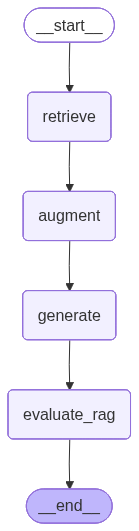

In [18]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

## 7. Invoke the Workflow with a Query

In [19]:
reference = [
    {
        "question": "What are Open source models?",
        "ground_truth": "Open-source models are AI or machine learning " 
                        "models whose code, architecture, and in some cases, " 
                        "training data and weights, are publicly available for " 
                        "use, modification, and distribution. They enable " 
                        "collaboration, transparency, and innovation by allowing " 
                        "developers to fine-tune, deploy, or improve them without " 
                        "proprietary restrictions.",
    }
]

In [20]:
output = graph.invoke(
    {
        "question": reference[0]["question"],
        "ground_truth": reference[0]["ground_truth"],
        "run_id": mlflow_run_id
    }
)

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


{'answer_relevancy': 0.9085, 'context_precision': 1.0000, 'faithfulness': 1.0000, 'context_recall': 1.0000}
🏃 View run l4_exercise_02 at: http://127.0.0.1:5000/#/experiments/2/runs/4e314ef32a0846c1851ac50efa9ae80b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


## 8. Inspect in MLFlow

In [21]:
# Get MLFlow Run with .get_run()
mflow_client.get_run(run_id=mlflow_run_id)

<Run: data=<RunData: metrics={'answer_relevancy': 0.9084757289407338,
 'context_precision': 0.9999999999,
 'context_recall': 1.0,
 'faithfulness': 1.0}, params={'embeddings_model': 'text-embedding-3-large',
 'llm_judge_model': 'gpt-4o',
 'llm_model': 'gpt-4o-mini'}, tags={'mlflow.runName': 'l4_exercise_02',
 'mlflow.source.name': '/home/thorsten/code/nd901-agentic-ai-with-langchain-and-langgraph/.venv/lib/python3.12/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'thorsten'}>, info=<RunInfo: artifact_uri='/mlflow/artifacts/2/4e314ef32a0846c1851ac50efa9ae80b/artifacts', end_time=1765172896323, experiment_id='2', lifecycle_stage='active', run_id='4e314ef32a0846c1851ac50efa9ae80b', run_name='l4_exercise_02', start_time=1765172876965, status='FINISHED', user_id='thorsten'>, inputs=<RunInputs: dataset_inputs=[], model_inputs=[]>, outputs=<RunOutputs: model_outputs=[]>>

## 9. Experiment

Now that you understood how it works, experiment with new things.

- Change RAG parameters: embedding model, chunk_size, chunk_overlap...
- Create multiple runs
- Improve your reference with more questions and ground_truth answers
- Use the results to understand what are the best parameters
- Create an Agent that picks the best combination

In [22]:

print("tracking_uri:", mlflow.get_tracking_uri())

tracking_uri: http://127.0.0.1:5000
